In [61]:
import random
import numpy as np
from deap import base, creator, tools
import matplotlib.pyplot as plt
import copy
import elitism
import json

In [62]:
with open('./real_data.json', 'r') as file:
    data = json.load(file)
data = data[0]
# data

In [63]:
stations = [list(map(int, x)) for x in data['stations'].values()]
LEN_STATIONS = len(stations)
# stations

In [64]:
trains = [x for x in data['full_timetable'].values()]
# trains

In [65]:
for train in trains:
    train['free_carriage'].append(0)

In [66]:
def convert_train_to_time_list(train_list):
    train_by_time = []
    for train_id in range(len(train_list)):
        time_list = train_list[train_id]['timetable']

        for i, time in enumerate(time_list):
            before_after = time.split('-')  # [05:24, 05:56]

            for j, rout_part in enumerate(before_after):
                free_carriage = int(train_list[train_id]['free_carriage'][i]) if j == 1 else None
                free_carriage = None if free_carriage == 0 else free_carriage
                hour, minut = [int(x) for x in rout_part.split(':')]
                new_t = hour * 100 + minut
                if i > 0 and train_by_time[-1]['time'] > new_t:
                    new_t *= 1000
                
                train_by_time.append({
                    'id': train_id, 
                    'time': new_t,
                    'st': int(train_list[train_id]['route'][i]), 
                    'free_carriage': free_carriage
                })
    return train_by_time

In [67]:
train_to_time = convert_train_to_time_list(trains)
train_to_time = sorted(train_to_time, key = lambda x: x['time'])
# train_to_time

In [68]:
train_onboard_main = [[0] * LEN_STATIONS for _ in range(len(data['full_timetable']))]
# train_onboard_main

In [69]:
HROM_LENGHT = sum([1 for x in train_to_time if x['free_carriage'] is not None])


# константы генетического алгоритма
POPULATION_SIZE = 10   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 10    # максимальное количество поколений
HALL_OF_FAME_SIZE = 1
INDIVID_SIZE = LEN_STATIONS

MAX_INDIVID = max([int(y) for x in [i['free_carriage'] for i in trains] for y in x])

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [70]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, LayerNormalization
import keras

In [71]:
TRAIN_INTERVAL = 2

first_count = LEN_STATIONS * 3 + LEN_STATIONS * TRAIN_INTERVAL + TRAIN_INTERVAL

model = keras.Sequential(
    [
        Input(shape=(first_count,), name='digits'),
        LayerNormalization(axis=1),
        Dense(first_count, activation="relu"),
        Dense(first_count // 2, activation="relu"),
        Dense(LEN_STATIONS, activation='relu'),
    ]
)

In [72]:

import tensorflow as tf
optimiser = tf.keras.optimizers.RMSprop()
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_2 (Lay  (None, 37)                74        
 erNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 37)                1406      
                                                                 
 dense_7 (Dense)             (None, 18)                684       
                                                                 
 dense_8 (Dense)             (None, 7)                 133       
                                                                 
Total params: 2297 (8.97 KB)
Trainable params: 2297 (8.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [74]:
def create_individ(count):
    res = np.random.rand(count) * 2 - 1
    return creator.Individual(res)

In [75]:
toolbox = base.Toolbox()
toolbox.register("individualCreator", create_individ, model.count_params())
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [76]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# population[0]

In [77]:
def get_train_leave(time, st, count):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st and train['free_carriage'] is not None:
            res.append(train['free_carriage'])

        if len(res) == count:
            return res
    
    i = len(res)
    
    for _ in range(i, count):
        res.append(0)
    return res


def get_train_comes(time, st, count, train_onboard):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st and train['free_carriage'] is not None:
            res.extend(train_onboard[train['id']])
        
        if len(res) == count * LEN_STATIONS:
            return res

    i = len(res) // LEN_STATIONS
    
    for _ in range(i, count):
        res.extend([0] * LEN_STATIONS)
    return res

In [78]:
def get_total_import(new_stations):
    column_sums = []
    for j in range(len(new_stations)):
        column_sum = 0
        for i in range(len(new_stations)):
            column_sum += new_stations[i][j]
        column_sums.append(column_sum)
    return column_sums

In [79]:
get_total_import(stations)

[121, 150, 94, 148, 100, 149, 106]

In [80]:
PENALTY_COST = 200

def shedule_cost(individual, model):
    individ = np.array(copy.deepcopy(individual))
    # print(individ[:5])
    train_onboard = copy.deepcopy(train_onboard_main)
    current_cost = 0
    new_stations = copy.deepcopy(stations)

    for st in new_stations:  # добавляем время простоя каждого вагона
        st.extend([0] * LEN_STATIONS)

    # print(new_stations)
    sp_ranges = []
    prev = 0
    for lay in model.get_weights():
        prev += np.prod(lay.shape)
        sp_ranges.append(prev)

    ws = np.split(individ, sp_ranges[:-1])
    model.set_weights([w.reshape(lay.shape) for w,lay in zip(ws, model.get_weights())])

    prev_time = train_to_time[0]['time'] // 100 * 60 + train_to_time[0]['time']
    for i in range(len(train_to_time)):
        train = train_to_time[i]
        time = train['time']
        delta_time = time // 100 * 60 + time - prev_time
        prev_time += delta_time
        station = train['st'] - 1
        if train['free_carriage'] is None:  # если было прибытие поезда
            for vagon_type in range(LEN_STATIONS):
                if vagon_type != station:  # если вагоны приехали не сюда, то считаем
                    new_stations[station][vagon_type] += train_onboard[train['id']][vagon_type]
                train_onboard[train['id']][vagon_type] = 0
            continue
        
        # если было отбытие поезда

        station_resources = copy.deepcopy(new_stations[station][:LEN_STATIONS])
        total_export = [sum(st[:LEN_STATIONS]) for st in new_stations]
        total_import = get_total_import(new_stations)
        coming_trains_info = get_train_comes(time, station, TRAIN_INTERVAL, train_onboard)
        leaving_trains_info = get_train_leave(time, station, TRAIN_INTERVAL)

        pred = model.predict([[*station_resources, *total_export, *total_import, *coming_trains_info, *leaving_trains_info]])[0]
        
        # delta_time = 42
        delta_vagons = [0 for _ in range(LEN_STATIONS)]

        onboard_val = 0
        for _ in range(len(pred)):
            curr_id = np.argmax(pred)
            avaiable_val = min(train['free_carriage'] - onboard_val, new_stations[station][curr_id])

            onboard_val += avaiable_val
            if onboard_val > train['free_carriage']:
                break

            delta_vagons[curr_id] += avaiable_val

            pred[curr_id] = -1

        for vagon_type in range(LEN_STATIONS):
            c = new_stations[station][vagon_type + LEN_STATIONS]
            vagons = new_stations[station][vagon_type]
            new_vagons = vagons + delta_vagons[vagon_type]
            if (new_vagons <= 0):
                new_stations[station][vagon_type + LEN_STATIONS] = 0
                new_stations[station][vagon_type] = 0
            else:
                new_stations[station][vagon_type + LEN_STATIONS] = (c * vagons + delta_time) / new_vagons
                new_stations[station][vagon_type] += delta_vagons[vagon_type]
            train_onboard[train['id']][vagon_type] += delta_vagons[vagon_type]

        row_sums = []
        for row in new_stations:
            row_sum = float(sum(row[-LEN_STATIONS:])) / float(sum(row[:LEN_STATIONS]))
            row_sums.append(row_sum)

        current_cost += sum(row_sums) / LEN_STATIONS
        
    return current_cost,

In [81]:
def mate(ind1, ind2):
    ind1, ind2 = tools.cxBlend(ind1, ind2, 0.5)
    return ind1, ind2

def mut(individual, indpb):           
    individual = tools.mutPolynomialBounded(individual, low=-1, up=1, eta=20, indpb=indpb)
    return individual,

In [82]:
toolbox.register("evaluate", shedule_cost, model=model)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=-1, up=1, eta=20, indpb=1.0/HROM_LENGHT)

In [83]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [84]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [85]:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 41ms/step
gen	nevals	min    	avg    
0  	10    	4.32795	6.07166
1/1 [==============================] - 0s 43ms/step
1  	9     	4.32795	5.4023 
1/1 [==============================] - 0s 37ms/step
2  	7     	4.32795	5.49624
1/1 [==============================] - 0s 40ms/step
3  	6     	4.32795	5.28289
1/1 [==============================] - 0s 33ms/step
4  	8     	4.19152	5.02788
1/1 [==============================] - 0s 37ms/step
5  	8     	4.19152	4.91556
1/1 [==============================] - 0s 86ms/step


KeyboardInterrupt: 

In [ ]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

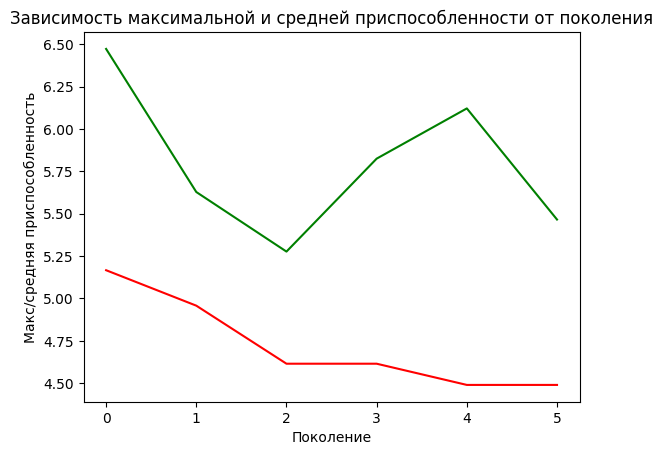

In [ ]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [ ]:
best_shedule = hof.items[0]

In [ ]:
sp_ranges = []
prev = 0
for lay in model.get_weights():
    prev += np.prod(lay.shape)
    sp_ranges.append(prev)

ws = np.split(best_shedule, sp_ranges[:-1])
model.set_weights([w.reshape(lay.shape) for w,lay in zip(ws, model.get_weights())])

In [ ]:
# model.save(f'pop_{POPULATION_SIZE}_gen_{MAX_GENERATIONS}.keras')